## Title
##Shock Index based Prediction of Acute Hypotensive Episodes using PPG Signal

In [ ]:
# Edit all the Mardown cells below with the appropriate information 
# Run all cells, containing your code 
# Save this Jupyter with the outputs of your executed cells
#
# PS: Save again the notebook with this outcome.
# PSPS: Don't forget to include the dataset in your submission

**Team:**
* Sneha Kumble Manohara
* Kiran Kumar Reddy


**Course:** DAAN 897– Deep Learning (Spring, 2023)

### Problem Statement
* The goal of our project is to predict acute hypotensive episode in selected ICU patients using photoplethysmography signal to detect an elevated shock index.

Acute hypotensive episodes, also known as sudden drops in blood pressure, can be a serious medical condition and can lead to various negative health outcomes if not treated promptly. Acute hypotensive episodes (AHE), defined as a drop in the mean arterial pressure (MAP) <65 mm Hg lasting at least 15 consecutive minutes, are among the most critical events in the intensive care unit (ICU). They are known to be associated with adverse outcome in critically ill patients. AHE prediction is of prime interest because it could allow for treatment adjustment to predict or shorten AHE. We will be predicting Acute Hypotensive Episodes based on Shock Index using Photoplethysmography (PPG) signals. Shock index is a simple clinical tool that can be used to predict acute hypotensive episodes. The shock index is calculated by dividing the heart rate by the systolic blood pressure. A high shock index (greater than 1) indicates that a patient may be at risk for an acute hypotensive episode.
    
    
    
* **Keywords:** Acute hypotensive episode, photoplethysmography Signal, Shock Index
	

### Data Collection
* Source(url): https://physionet.org/content/mimiciv/0.4/
* Short Description : The data for this challenge comes from MIMIC IV((Medical Information Mart for Intensive Care) which comprises of deidentified health data associated with thousands of intensive care unit admissions. MIMIC-IV is sourced from two in-hospital database systems: a custom hospital wide EHR and an ICU specific clinical information system. A master patient list was created which contained all medical record numbers corresponding to patients admitted to an ICU or the emergency department between 2008 - 2019. Numeric data are obtained from high-frequency collection of a set of vital signals. This set includes at least HR, pulse oximetry, and blood pressure (peripheral oxygen saturation [Spo2]), and invasive arterial blood pressures (systolic, diastolic, and mean).

* Keywords: MIMIC IV, intensive care unit admissions, HR, pulse oximetry, and blood pressure (peripheral oxygen saturation [Spo2]), and invasive arterial blood pressures.

### Required packages

* Add instructions to install the required packages


In [1]:
## Your code begins here
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
%cd /content/drive/MyDrive

/content/drive/MyDrive


In [93]:
#imports
import pandas as pd
import seaborn as sns
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, LSTM, GRU, Embedding
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import RandomizedSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from keras.layers import Dropout
!pip install keras-tuner
import keras_tuner
from tensorflow import keras


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.3/167.3 KB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 64.4 MB/s eta 0:00:00


In [4]:


# Load CSV file into a pandas dataframe

# HOSP module data
admissions = pd.read_csv('admissions.csv')

diagnoses_icd = pd.read_csv('diagnoses_icd.csv')

patients = pd.read_csv('patients.csv')

# ICU data
icustays = pd.read_csv('icustays.csv')

# Chart Events
chart_events = pd.read_csv('Final_Chart_Event.csv')

The final dataset for our project, is formed by merging 4 other tables namely:

**admissions**: This table contains information about each hospital admission, such as admission and discharge times and primary diagnosis. We filtered out only the features that were required for the prediction of acute hypotensive episodes.

**patients**: This table contains demographic information for each patient, including age, sex, and ethnicity. We filtered out only the features that were required for the prediction of acute hypotensive episodes.

**diagnoses_icd**: This table contains ICD-10 and ICD-9 diagnosis codes for each hospital admission. Another column named AHE was created for predicting AHE. If the icd_id that indicates the diagnosis had a value of R55 or I959 which is the code for Acute hypotensive episode, then the AHE was encoded as 1 and the rest of the icd_cd was encoded to 0.

**icustays**: This table contains information about each ICU stay, including admission and discharge times, as well as whether or not the patient experienced a hypotensive episode. We filtered out only the features that were required for the prediction of acute hypotensive episodes.

**chartevents**: This table contains time-stamped values for various clinical measurements, including PPG signals, blood pressure, and heart rate. For our analysis, we considered all the data that had item_id 220045(heart rate), 220179(Systolic blood pressure (SBP)), 220180(Diastolic blood pressure (DBP)). Since the prediction of Acute Hypotensive episodes require Mean arterial pressure (MAP), we calculated the MAP value using the equation MAP = [(2 x diastolic)+systolic] / 3 and created a column for MAP. Shock index column was created by dividing HeartRate by Systolic Blood Pressure.


In [5]:
admissions.head()

,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,admit_provider_id,admission_location,discharge_location,insurance,language,marital_status,race,edregtime,edouttime,hospital_expire_flag
0,10000032,22595853,2180-05-06 22:23:00,2180-05-07 17:15:00,NaN,URGENT,P874LG,TRANSFER FROM HOSPITAL,HOME,Other,ENGLISH,WIDOWED,WHITE,2180-05-06 19:17:00,2180-05-06 23:30:00,0
1,10000032,22841357,2180-06-26 18:27:00,2180-06-27 18:49:00,NaN,EW EMER.,P09Q6Y,EMERGENCY ROOM,HOME,Medicaid,ENGLISH,WIDOWED,WHITE,2180-06-26 15:54:00,2180-06-26 21:31:00,0
2,10000032,25742920,2180-08-05 23:44:00,2180-08-07 17:50:00,NaN,EW EMER.,P60CC5,EMERGENCY ROOM,HOSPICE,Medicaid,ENGLISH,WIDOWED,WHITE,2180-08-05 20:58:00,2180-08-06 01:44:00,0
3,10000032,29079034,2180-07-23 12:35:00,2180-07-25 17:55:00,NaN,EW EMER.,P30KEH,EMERGENCY ROOM,HOME,Medicaid,ENGLISH,WIDOWED,WHITE,2180-07-23 05:54:00,2180-07-23 14:00:00,0
4,10000068,25022803,2160-03-03 23:16:00,2160-03-04 06:26:00,NaN,EU OBSERVATION,P51VDL,EMERGENCY ROOM,NaN,Other,ENGLISH,SINGLE,WHITE,2160-03-03 21:55:00,2160-03-04 06:26:00,0


In [7]:
admissions.columns

Index(['subject_id', 'hadm_id', 'admittime', 'dischtime', 'deathtime',
       'admission_type', 'admit_provider_id', 'admission_location',
       'discharge_location', 'insurance', 'language', 'marital_status', 'race',
       'edregtime', 'edouttime', 'hospital_expire_flag'],
      dtype='object')

In [8]:
admissions = admissions[['subject_id', 'hadm_id', 'deathtime','admission_type', 'admission_location'
                         , 'insurance', 'race', 'hospital_expire_flag']]

In [9]:
admissions

,subject_id,hadm_id,deathtime,admission_type,admission_location,insurance,race,hospital_expire_flag
0,10000032,22595853,NaN,URGENT,TRANSFER FROM HOSPITAL,Other,WHITE,0
1,10000032,22841357,NaN,EW EMER.,EMERGENCY ROOM,Medicaid,WHITE,0
2,10000032,25742920,NaN,EW EMER.,EMERGENCY ROOM,Medicaid,WHITE,0
3,10000032,29079034,NaN,EW EMER.,EMERGENCY ROOM,Medicaid,WHITE,0
4,10000068,25022803,NaN,EU OBSERVATION,EMERGENCY ROOM,Other,WHITE,0
...,...,...,...,...,...,...,...,...
431226,19999828,25744818,NaN,EW EMER.,TRANSFER FROM HOSPITAL,Other,WHITE,0
431227,19999828,29734428,NaN,EW EMER.,PHYSICIAN REFERRAL,Other,WHITE,0
431228,19999840,21033226,2164-09-17 13:42:00,EW EMER.,EMERGENCY ROOM,Other,WHITE,1
431229,19999840,26071774,NaN,EW EMER.,EMERGENCY ROOM,Other,WHITE,0


In [10]:
diagnoses_icd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4756326 entries, 0 to 4756325
Data columns (total 5 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   subject_id   int64 
 1   hadm_id      int64 
 2   seq_num      int64 
 3   icd_code     object
 4   icd_version  int64 
dtypes: int64(4), object(1)
memory usage: 181.4+ MB


In [11]:
diagnoses_icd.head()

,subject_id,hadm_id,seq_num,icd_code,icd_version
0,10000032,22595853,1,5723,9
1,10000032,22595853,2,78959,9
2,10000032,22595853,3,5715,9
3,10000032,22595853,4,07070,9
4,10000032,22595853,5,496,9


In [12]:
Hypotensive_ICD_Codes = ['O265', 'R50', 'R51', 'R52', 'R53', 'R54', 'R55', 'R56', 'R57', 'R58', 'R59', 'R60', 'R61', 'R62', 'R63', 'R64', 'R65', 
     'R66', 'R67', 'R68', 'R69', 'I95', 'I950', 'I951', 'I952', 'I953', 'I958', 'I959', '458', '4580', '4581', '4582', '4588', 
     '4589']

In [13]:
# filter the rows that contain the hypotensive ICD codes
diagnoses_icd = diagnoses_icd[diagnoses_icd['icd_code'].isin(Hypotensive_ICD_Codes)]

diagnoses_icd

,subject_id,hadm_id,seq_num,icd_code,icd_version
452,10001338,29335220,2,4580,9
1115,10002013,28603984,10,4589,9
1227,10002155,28994087,11,4589,9
1588,10002528,23193578,4,I951,10
1757,10002930,20282368,7,R51,10
...,...,...,...,...,...
4755868,19998878,27930413,18,4589,9
4755890,19999043,23037011,3,I959,10
4756053,19999464,23033573,3,R51,10
4756220,19999784,29234099,6,R51,10


In [14]:
Acute_Hypotensive_ICD_Codes = ['R55', 'I959']

In [15]:
# create a new column with all 0s
diagnoses_icd['AHE'] = 0

# label the values in the list as 1
diagnoses_icd.loc[diagnoses_icd['icd_code'].isin(Acute_Hypotensive_ICD_Codes), 'AHE'] = 1

In [16]:
diagnoses_icd

,subject_id,hadm_id,seq_num,icd_code,icd_version,AHE
452,10001338,29335220,2,4580,9,0
1115,10002013,28603984,10,4589,9,0
1227,10002155,28994087,11,4589,9,0
1588,10002528,23193578,4,I951,10,0
1757,10002930,20282368,7,R51,10,0
...,...,...,...,...,...,...
4755868,19998878,27930413,18,4589,9,0
4755890,19999043,23037011,3,I959,10,1
4756053,19999464,23033573,3,R51,10,0
4756220,19999784,29234099,6,R51,10,0


In [18]:
# reset the index of diagnoses_icd
diagnoses_icd.reset_index(drop=True, inplace=True)

In [19]:
diagnoses_icd['AHE'].value_counts()

0    18170
1     7770
Name: AHE, dtype: int64

In [20]:
# Select the subject_id, hadm_id, and icd_code columns
diagnoses_icd = diagnoses_icd[['subject_id', 'hadm_id', 'icd_code', 'AHE']]

In [21]:
patients.head()

,subject_id,gender,anchor_age,anchor_year,anchor_year_group,dod
0,10000032,F,52,2180,2014 - 2016,2180-09-09
1,10000048,F,23,2126,2008 - 2010,NaN
2,10000068,F,19,2160,2008 - 2010,NaN
3,10000084,M,72,2160,2017 - 2019,2161-02-13
4,10000102,F,27,2136,2008 - 2010,NaN


In [22]:
patients = patients[['subject_id', 'gender', 'anchor_age']]

In [23]:
patients

,subject_id,gender,anchor_age
0,10000032,F,52
1,10000048,F,23
2,10000068,F,19
3,10000084,M,72
4,10000102,F,27
...,...,...,...
299707,19999828,F,46
299708,19999829,F,28
299709,19999840,M,58
299710,19999914,F,49


In [24]:
icustays.head()

,subject_id,hadm_id,stay_id,first_careunit,last_careunit,intime,outtime,los
0,10000032,29079034,39553978,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2180-07-23 14:00:00,2180-07-23 23:50:47,0.410266
1,10000980,26913865,39765666,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2189-06-27 08:42:00,2189-06-27 20:38:27,0.497535
2,10001217,24597018,37067082,Surgical Intensive Care Unit (SICU),Surgical Intensive Care Unit (SICU),2157-11-20 19:18:02,2157-11-21 22:08:00,1.118032
3,10001217,27703517,34592300,Surgical Intensive Care Unit (SICU),Surgical Intensive Care Unit (SICU),2157-12-19 15:42:24,2157-12-20 14:27:41,0.948113
4,10001725,25563031,31205490,Medical/Surgical Intensive Care Unit (MICU/SICU),Medical/Surgical Intensive Care Unit (MICU/SICU),2110-04-11 15:52:22,2110-04-12 23:59:56,1.338588


In [25]:
icustays.columns

Index(['subject_id', 'hadm_id', 'stay_id', 'first_careunit', 'last_careunit',
       'intime', 'outtime', 'los'],
      dtype='object')

In [26]:
admissions.head()

,subject_id,hadm_id,deathtime,admission_type,admission_location,insurance,race,hospital_expire_flag
0,10000032,22595853,NaN,URGENT,TRANSFER FROM HOSPITAL,Other,WHITE,0
1,10000032,22841357,NaN,EW EMER.,EMERGENCY ROOM,Medicaid,WHITE,0
2,10000032,25742920,NaN,EW EMER.,EMERGENCY ROOM,Medicaid,WHITE,0
3,10000032,29079034,NaN,EW EMER.,EMERGENCY ROOM,Medicaid,WHITE,0
4,10000068,25022803,NaN,EU OBSERVATION,EMERGENCY ROOM,Other,WHITE,0


In [27]:
admissions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 431231 entries, 0 to 431230
Data columns (total 8 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   subject_id            431231 non-null  int64 
 1   hadm_id               431231 non-null  int64 
 2   deathtime             8598 non-null    object
 3   admission_type        431231 non-null  object
 4   admission_location    431231 non-null  object
 5   insurance             431231 non-null  object
 6   race                  431231 non-null  object
 7   hospital_expire_flag  431231 non-null  int64 
dtypes: int64(3), object(5)
memory usage: 26.3+ MB


In [28]:
diagnoses_icd.head()

,subject_id,hadm_id,icd_code,AHE
0,10001338,29335220,4580,0
1,10002013,28603984,4589,0
2,10002155,28994087,4589,0
3,10002528,23193578,I951,0
4,10002930,20282368,R51,0


In [29]:
diagnoses_icd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25940 entries, 0 to 25939
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   subject_id  25940 non-null  int64 
 1   hadm_id     25940 non-null  int64 
 2   icd_code    25940 non-null  object
 3   AHE         25940 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 810.8+ KB


In [30]:
# perform an inner join on subject_id column
ad_diag = pd.merge(admissions, diagnoses_icd, on=['hadm_id', 'subject_id'], how='inner')

In [31]:
ad_diag.head()

,subject_id,hadm_id,deathtime,admission_type,admission_location,insurance,race,hospital_expire_flag,icd_code,AHE
0,10001338,29335220,NaN,EU OBSERVATION,EMERGENCY ROOM,Other,WHITE,0,4580,0
1,10002013,28603984,NaN,EW EMER.,PACU,Medicaid,WHITE,0,4589,0
2,10002155,28994087,NaN,EW EMER.,EMERGENCY ROOM,Other,WHITE,0,4589,0
3,10002528,23193578,NaN,OBSERVATION ADMIT,TRANSFER FROM HOSPITAL,Other,WHITE,0,I951,0
4,10002930,20282368,NaN,EU OBSERVATION,PHYSICIAN REFERRAL,Medicare,BLACK/AFRICAN AMERICAN,0,R51,0


In [32]:
ad_diag_pat = pd.merge(ad_diag, patients, on='subject_id', how='inner')

In [33]:
ad_diag_pat.head()

,subject_id,hadm_id,deathtime,admission_type,admission_location,insurance,race,hospital_expire_flag,icd_code,AHE,gender,anchor_age
0,10001338,29335220,NaN,EU OBSERVATION,EMERGENCY ROOM,Other,WHITE,0,4580,0,F,43
1,10002013,28603984,NaN,EW EMER.,PACU,Medicaid,WHITE,0,4589,0,F,53
2,10002155,28994087,NaN,EW EMER.,EMERGENCY ROOM,Other,WHITE,0,4589,0,F,80
3,10002528,23193578,NaN,OBSERVATION ADMIT,TRANSFER FROM HOSPITAL,Other,WHITE,0,I951,0,F,26
4,10002930,20282368,NaN,EU OBSERVATION,PHYSICIAN REFERRAL,Medicare,BLACK/AFRICAN AMERICAN,0,R51,0,F,48


In [34]:
ad_diag_pat_icustays = pd.merge(ad_diag_pat, icustays, on=['subject_id', 'hadm_id'] , how='inner')

In [35]:
ad_diag_pat_icustays = ad_diag_pat_icustays[['subject_id',	'hadm_id', 'stay_id', 'gender',	'anchor_age', 'AHE']]

In [36]:
ad_diag_pat_icustays.head()

,subject_id,hadm_id,stay_id,gender,anchor_age,AHE
0,10002155,28994087,31090461,F,80,0
1,10004720,22081550,35009126,M,61,1
2,10004764,24817563,32104791,M,70,1
3,10005348,25239799,34629895,M,76,0
4,10005866,20364112,34170353,M,57,1


In [37]:
chart_events = chart_events[['subject_id', 'hadm_id', 'stay_id', 'heart_rate(BPM)', 'sbp(mmHg)', 'dbp(mmHg)', 'MAP(mmHg)']]

In [38]:
final_df_1 = pd.merge(ad_diag_pat_icustays, chart_events, on=['subject_id', 'hadm_id', 'stay_id'] , how='inner')

In [39]:
final_df_1['AHE'].value_counts()

0    178095
1     31446
Name: AHE, dtype: int64

In [40]:
final_df_1 = final_df_1[['gender',	'anchor_age',	'heart_rate(BPM)',	'sbp(mmHg)',	'dbp(mmHg)',	'MAP(mmHg)',	'AHE']]

In [41]:
final_df_1.head()

,gender,anchor_age,heart_rate(BPM),sbp(mmHg),dbp(mmHg),MAP(mmHg),AHE
0,F,80,84.0,124.0,50,74.666667,0
1,F,80,77.0,91.0,33,52.333333,0
2,F,80,73.0,114.0,26,55.333333,0
3,F,80,92.0,89.0,38,55.000000,0
4,F,80,81.0,77.0,25,42.333333,0


**Exploratory Data Analysis:**
After merging all the required tables, we formed a final dataset. This dataset includes 209541 rows and 7 columns. 6 input features and 1 output column — ‘AHE’. The data types of this dataset included int, float and object.

In [42]:
final_df_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 209541 entries, 0 to 209540
Data columns (total 7 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   gender           209541 non-null  object 
 1   anchor_age       209541 non-null  int64  
 2   heart_rate(BPM)  209541 non-null  float64
 3   sbp(mmHg)        209541 non-null  float64
 4   dbp(mmHg)        209541 non-null  int64  
 5   MAP(mmHg)        209541 non-null  float64
 6   AHE              209541 non-null  int64  
dtypes: float64(3), int64(3), object(1)
memory usage: 12.8+ MB


In [43]:
final_df_1.describe().T

,count,mean,std,min,25%,50%,75%,max
anchor_age,209541.0,64.584840,15.951393,18.0,55.0,65.000000,77.000000,91.000000
heart_rate(BPM),209541.0,86.625855,18.657063,0.0,73.0,85.000000,98.000000,219.000000
sbp(mmHg),209541.0,113.471349,21.631551,0.0,98.0,110.000000,126.000000,840.000000
dbp(mmHg),209541.0,63.547296,189.959591,0.0,52.0,61.000000,71.000000,82107.000000
MAP(mmHg),209541.0,80.188647,127.159247,0.0,69.0,77.666667,88.333333,54773.666667
AHE,209541.0,0.150071,0.357142,0.0,0.0,0.000000,0.000000,1.000000


### Data Preprocessing

* Enumerate and present the main steps you preformed in the data preprocessing
* Add your code and interpret the outcome of main steps/functions


In [46]:
## Your code begins here
# Check for duplicates
duplicates = final_df_1.duplicated()

# Count the number of duplicates
num_duplicates = duplicates.sum()

# Print the number of duplicates
print(f"There are {num_duplicates} duplicates in final_df_1.")

There are 4210 duplicates in final_df_1.


In [47]:
# Drop duplicates
final_df_2 = final_df_1.drop_duplicates()

# Check the shape of the dataframe after dropping duplicates
print(f"The shape of final_df_2 after dropping duplicates is: {final_df_2.shape}")

The shape of final_df_2 after dropping duplicates is: (205331, 7)


In [48]:
final_df_2['sbp(mmHg)'] = final_df_2['sbp(mmHg)'].astype(int)
final_df_2['dbp(mmHg)'] = final_df_2['dbp(mmHg)'].astype(int)
final_df_2['MAP(mmHg)'] = final_df_2['MAP(mmHg)'].astype(int)
final_df_2['heart_rate(BPM)'] = final_df_2['heart_rate(BPM)'].astype(int)
final_df_2

<ipython-input-48-59ef39c43673>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df_2['sbp(mmHg)'] = final_df_2['sbp(mmHg)'].astype(int)
<ipython-input-48-59ef39c43673>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df_2['dbp(mmHg)'] = final_df_2['dbp(mmHg)'].astype(int)
<ipython-input-48-59ef39c43673>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

,gender,anchor_age,heart_rate(BPM),sbp(mmHg),dbp(mmHg),MAP(mmHg),AHE
0,F,80,84,124,50,74,0
1,F,80,77,91,33,52,0
2,F,80,73,114,26,55,0
3,F,80,92,89,38,55,0
4,F,80,81,77,25,42,0
...,...,...,...,...,...,...,...
209536,M,58,62,79,42,54,0
209537,M,58,63,108,57,74,0
209538,M,58,76,111,53,72,0
209539,M,58,89,79,42,54,0


In [49]:
# Check for missing values
missing_values = final_df_2.isna()

# Count the number of missing values in each column
num_missing_values = missing_values.sum()

# Print the number of missing values in each column
print("Number of missing values in each column:")
print(num_missing_values)

Number of missing values in each column:
gender             0
anchor_age         0
heart_rate(BPM)    0
sbp(mmHg)          0
dbp(mmHg)          0
MAP(mmHg)          0
AHE                0
dtype: int64


<AxesSubplot:>

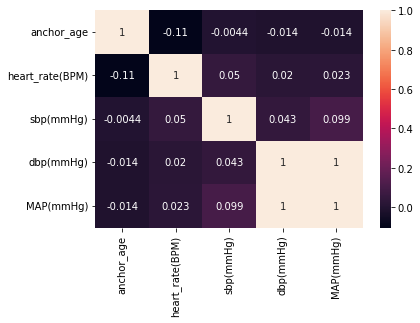

In [50]:
corr_matrix = final_df_2.drop('AHE', axis=1).corr()
sns.heatmap(corr_matrix, annot=True)

In [51]:
final_df_2 = final_df_2.drop('dbp(mmHg)', axis=1)

In [52]:
final_df_2

,gender,anchor_age,heart_rate(BPM),sbp(mmHg),MAP(mmHg),AHE
0,F,80,84,124,74,0
1,F,80,77,91,52,0
2,F,80,73,114,55,0
3,F,80,92,89,55,0
4,F,80,81,77,42,0
...,...,...,...,...,...,...
209536,M,58,62,79,54,0
209537,M,58,63,108,74,0
209538,M,58,76,111,72,0
209539,M,58,89,79,54,0


In [56]:
#remove
final_df_2.to_csv('final_df_2.csv', index=False)
final_df_2 = pd.read_csv('final_df_2.csv')
final_df_2

,gender,anchor_age,heart_rate(BPM),sbp(mmHg),MAP(mmHg),AHE
0,F,80,84,124,74,0
1,F,80,77,91,52,0
2,F,80,73,114,55,0
3,F,80,92,89,55,0
4,F,80,81,77,42,0
...,...,...,...,...,...,...
205326,M,58,62,79,54,0
205327,M,58,63,108,74,0
205328,M,58,76,111,72,0
205329,M,58,89,79,54,0


<AxesSubplot:>

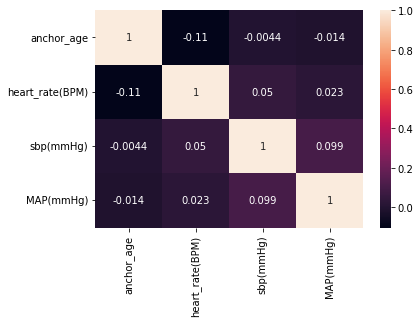

In [57]:
corr_matrix = final_df_2.drop('AHE', axis=1).corr()
sns.heatmap(corr_matrix, annot=True)

In [58]:
final_df_2['AHE'].value_counts()

0    174511
1     30820
Name: AHE, dtype: int64

In [59]:
# down sampling

# read in your original dataframe
df = final_df_2

# create separate dataframes for rows with AHE=0 and AHE=1
df_0 = df[df['AHE'] == 0]
df_1 = df[df['AHE'] == 1]

# randomly sample 50% of rows with AHE=0
df_0_sampled = df_0.sample(frac=0.4)

# concatenate the two dataframes back together
df_downsampled = pd.concat([df_0_sampled, df_1])

# # print the new dataframe to check the results
df_downsampled

,gender,anchor_age,heart_rate(BPM),sbp(mmHg),MAP(mmHg),AHE
46593,F,58,102,116,84,0
122169,F,62,64,93,61,0
74450,M,80,79,107,61,0
116820,M,61,108,111,79,0
175184,M,21,72,97,70,0
...,...,...,...,...,...,...
205122,F,52,97,109,76,1
205123,F,52,118,118,97,1
205124,F,52,110,129,99,1
205125,F,52,90,131,103,1


In [60]:
df_downsampled['AHE'].value_counts()

0    69804
1    30820
Name: AHE, dtype: int64

In [61]:
# One-hot encode categorical variables
df_downsampled_1 = pd.get_dummies(df_downsampled, columns=['gender'])

In [62]:
# reset the index of the new dataframe
df_downsampled_1 = df_downsampled_1.reset_index(drop=True)

In [63]:
df_downsampled_1 = df_downsampled_1[df_downsampled_1['sbp(mmHg)'] != 0]

In [64]:
df_downsampled_1['Shock_Index'] = df_downsampled_1['heart_rate(BPM)'] / df_downsampled_1['sbp(mmHg)']

In [65]:
df_downsampled_1

,anchor_age,heart_rate(BPM),sbp(mmHg),MAP(mmHg),AHE,gender_F,gender_M,Shock_Index
0,58,102,116,84,0,1,0,0.879310
1,62,64,93,61,0,1,0,0.688172
2,80,79,107,61,0,0,1,0.738318
3,61,108,111,79,0,0,1,0.972973
4,21,72,97,70,0,0,1,0.742268
...,...,...,...,...,...,...,...,...
100619,52,97,109,76,1,1,0,0.889908
100620,52,118,118,97,1,1,0,1.000000
100621,52,110,129,99,1,1,0,0.852713
100622,52,90,131,103,1,1,0,0.687023


In [95]:
# Separate target variable and predictors
X = df_downsampled_1.drop('AHE', axis=1)
y = df_downsampled_1['AHE']

As a part of data cleaning, we performed many steps like feature removal, outlier detection, imbalanced data detection, downscaling of the dataset. The dataset had 4210 duplicate values. Since it contributed to just 2% of the dataset, we dropped it. All the float data types except for shock index were converted to integer.

After plotting the correlation plot, we found that MAP(mmHg) and dbp(mmHg) were highly correlated, hence we decided to drop dbp(mmHg).

•	The dataset was highly imbalanced with respect to AHE count. There were 174511 values with 0(without AHE) and only 30820 with the value 1(with AHE). Hence, we decided to perform downscaling the AHE values with 0 to the same number of AHE with 1 rows. After downscaling, the total count came down to 69804 from 174511 rows .The dataset is then split into 80:20 training and testing dataset. Gender variable was one hot encoded. Input data was normalized.



In [96]:
# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

The datset is split into train and test dataset into the ratio 80:20

In [97]:
# Normalize input data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
# X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [69]:
X_train.shape

(80492, 7)

In [70]:
X_test.shape

(20124, 7)

### Methodology

1. Explan your Deep Learning process / methodology
•	**Data collection and Data preparation**: After collecting all the relevant data from the MIMIC-IV dataset we performed data cleaning to remove duplicate value, imbalanced data. Removed all the irrelevant data. Further did normalization of the input data.

•	**Feature extraction**: Once we had the relevant dataset, we created another column which us the main predictor for our project that is the shock index. Shock index is calculated by dividing heart rate by systolic blood pressure.

•	**Model selection**: As we are performing binary classification, we chose CNN , LSTM and GRU models.

•	**Model development**: We developed and trained the model on the preprocessed and feature-extracted data. Further tuning of the hyperparameters were done to improve the model's performance. We evaluated the model using appropriate evaluation metrics such as accuracy, precision, recall, F1 score and the confusion matrix.

•	**Model deployment**: Further we deployed the trained model to make predictions on test data.





2. Introduce the Deep Neural Networks you used in your project
 * Model 1(CNN)
    * We performed binary classification using CNN model. The CNN model includes 2 convolution layers, 3 dense layers with activation functions such as relu and sigmoid.  
 
 * Model 2(LSTM)
    * We first normalized the input features. The LSTM model 2 LSTM layers. With sigmoid as the activation function. The model was trained with early stopping to prevent overfitting.

    Model 3(GRU)
    * The model is a binary classification model based on the Gated Recurrent Unit (GRU) architecture. The input data is expected to have a shape of (samples, time steps, features), where each sample is a sequence of PPG signals, each time step corresponds to a specific time point, and each feature corresponds to a specific PPG channel. The model consists of a single GRU layer with 64 units, followed by a dropout layer with a dropout rate of 0.2, and another GRU layer with 32 units. The second GRU layer is followed by another dropout layer with a dropout rate of 0.2, and a dense output layer with a single sigmoid activation unit for binary classification. The model is trained using early stopping with a patience of 5 epochs to prevent overfitting.The hyperparameters of the model was tuned using techniques such as grid search or random search to find the optimal values that can improve the model's performance.
 


### Model Fitting and Validation

1. model 1 
    - The CNN model gave an accuracy of Accuracy: 0.706 in the training dataset and 0.704 in the test dataset. The model does not seem to be overfitting or underfitting the model. The loss also decreased. 
2. model 2
    - The LSTM model gave an accuracy of Accuracy: 0.704 in the training dataset and 0.701 in the test dataset. The model does not seem to be overfitting or underfitting the model. The loss also decreased.

3. model 3
   -  The GRU model gave an accuracy of Accuracy: 0.713 in the training dataset and 0.713 in the test dataset. The model does not seem to be overfitting or underfitting the model. The loss also decreased. This model performed the best out of the three models after hypertuning the parameters

In [71]:
## Your code begins here
# CNN Model

# Define input shape
input_shape = (X_train.shape[1], 1)

# Define the model
cnn_model = Sequential()

# Add the convolutional layer
#model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape = input_shape))
cnn_model.add(Conv1D(filters=32, kernel_size=3, activation='relu', padding='same', input_shape=input_shape))

# Add the max pooling layer
cnn_model.add(MaxPooling1D(pool_size=2))

# Add another convolutional layer
# model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
cnn_model.add(Conv1D(filters=64, kernel_size=3, activation='sigmoid', padding='same'))

# Add another max pooling layer
cnn_model.add(MaxPooling1D(pool_size=2))

# Flatten the output from the convolutional layers
cnn_model.add(Flatten())

# Add the output layer
cnn_model.add(Dense(64, activation='relu'))

# Add the output layer
cnn_model.add(Dense(32, activation='sigmoid'))

# Add the output layer
cnn_model.add(Dense(1, activation='sigmoid'))

# Compile the model
cnn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
history = cnn_model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test))

Epoch 1/10
1258/1258 [==============================] - 9s 6ms/step - loss: 0.6124 - accuracy: 0.6925 - val_loss: 0.6035 - val_accuracy: 0.6969
Epoch 2/10
1258/1258 [==============================] - 5s 4ms/step - loss: 0.6068 - accuracy: 0.6929 - val_loss: 0.6006 - val_accuracy: 0.6969
Epoch 3/10
1258/1258 [==============================] - 7s 6ms/step - loss: 0.6028 - accuracy: 0.6930 - val_loss: 0.5984 - val_accuracy: 0.6970
Epoch 4/10
1258/1258 [==============================] - 7s 6ms/step - loss: 0.5992 - accuracy: 0.6946 - val_loss: 0.5933 - val_accuracy: 0.6981
Epoch 5/10
1258/1258 [==============================] - 7s 6ms/step - loss: 0.5966 - accuracy: 0.6960 - val_loss: 0.5919 - val_accuracy: 0.6991
Epoch 6/10
1258/1258 [==============================] - 11s 8ms/step - loss: 0.5943 - accuracy: 0.6968 - val_loss: 0.5912 - val_accuracy: 0.7007
Epoch 7/10
1258/1258 [==============================] - 10s 8ms/step - loss: 0.5926 - accuracy: 0.6980 - val_loss: 0.5893 - val_accurac

In [110]:
cnn_model.save_weights('cnn_model_weights.h5')

In [111]:
cnn_model.load_weights('cnn_model_weights.h5')

In [112]:
cnn_model.save('cnn_model.h5')

In [72]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']

print('Training Loss:', train_loss[-1])
print('Validation Loss:', val_loss[-1])
print('Accuracy:', accuracy[-1])

Training Loss: 0.5892623066902161
Validation Loss: 0.5862298011779785
Accuracy: 0.6996098756790161


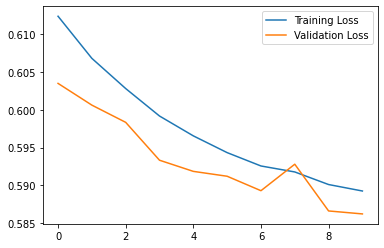

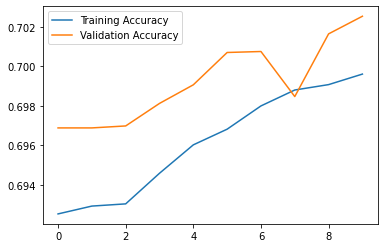

In [73]:
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend()
plt.show()

# Plot the training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()

In [74]:
# LSTM Model
# Normalize the features
mean = X_train.mean(axis=0)
std = X_train.std(axis=0)
X_train = (X_train - mean) / std
X_test = (X_test - mean) / std

# Reshape the features for LSTM input (samples, timesteps, features)
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))


# Define the LSTM model
model = Sequential()
model.add(LSTM(64, input_shape=(1, X_train.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(32, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model with early stopping
es = EarlyStopping(monitor='val_loss', patience=5)
history = model.fit(X_train, y_train, validation_split=0.2, epochs=10, batch_size=32, callbacks=[es])

# Evaluate the model on test data
test_loss, test_acc = model.evaluate(X_test, y_test)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

Epoch 1/10
2013/2013 [==============================] - 17s 6ms/step - loss: 0.6090 - accuracy: 0.6923 - val_loss: 0.6043 - val_accuracy: 0.6914
Epoch 2/10
2013/2013 [==============================] - 12s 6ms/step - loss: 0.6018 - accuracy: 0.6933 - val_loss: 0.6025 - val_accuracy: 0.6926
Epoch 3/10
2013/2013 [==============================] - 13s 6ms/step - loss: 0.6003 - accuracy: 0.6949 - val_loss: 0.6008 - val_accuracy: 0.6959
Epoch 4/10
2013/2013 [==============================] - 12s 6ms/step - loss: 0.5984 - accuracy: 0.6956 - val_loss: 0.6000 - val_accuracy: 0.6967
Epoch 5/10
2013/2013 [==============================] - 12s 6ms/step - loss: 0.5969 - accuracy: 0.6970 - val_loss: 0.5975 - val_accuracy: 0.6966
Epoch 6/10
2013/2013 [==============================] - 10s 5ms/step - loss: 0.5955 - accuracy: 0.6977 - val_loss: 0.5972 - val_accuracy: 0.6969
Epoch 7/10
2013/2013 [==============================] - 12s 6ms/step - loss: 0.5947 - accuracy: 0.6979 - val_loss: 0.5970 - val_ac

In [113]:
model.save_weights('LSTM_model_weights.h5')
model.load_weights('LSTM_model_weights.h5')
model.save('LSTM_model.h5')

In [75]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']

print('Training Loss:', train_loss[-1])
print('Validation Loss:', val_loss[-1])
print('Accuracy:', accuracy[-1])

Training Loss: 0.5927962064743042
Validation Loss: 0.5935006737709045
Accuracy: 0.6981970071792603


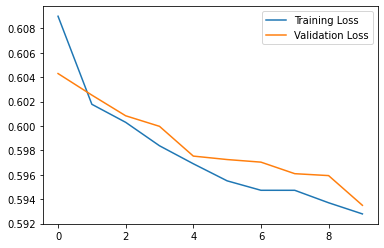

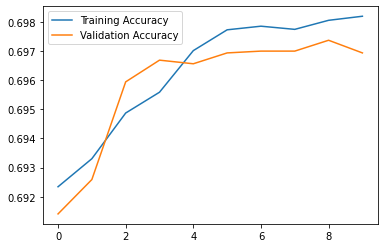

In [76]:
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend()
plt.show()

# Plot the training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()

In [86]:

# Calculate mean and standard deviation for normalization
mean = X_train.mean(axis=0)
std = X_train.std(axis=0)

# Normalize the data
X_train = (X_train - mean) / std
X_test = (X_test - mean) / std



# Define the model
model = Sequential()
model.add(GRU(32, input_shape=(X_train.shape[1], 1), return_sequences=True))
model.add(Dropout(0.2))
model.add(GRU(16, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model with early stopping
es = EarlyStopping(monitor='val_loss', patience=5)
history = model.fit(X_train, y_train, validation_split=0.2, epochs=10, batch_size=32, callbacks=[es])

# Evaluate the model on test data
test_loss, test_acc = model.evaluate(X_test, y_test)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)


Epoch 1/10
2013/2013 [==============================] - 32s 14ms/step - loss: 0.6154 - accuracy: 0.6928 - val_loss: 0.6129 - val_accuracy: 0.6928
Epoch 2/10
2013/2013 [==============================] - 25s 12ms/step - loss: 0.6111 - accuracy: 0.6929 - val_loss: 0.6107 - val_accuracy: 0.6927
Epoch 3/10
2013/2013 [==============================] - 25s 12ms/step - loss: 0.6089 - accuracy: 0.6928 - val_loss: 0.6090 - val_accuracy: 0.6924
Epoch 4/10
2013/2013 [==============================] - 24s 12ms/step - loss: 0.6062 - accuracy: 0.6939 - val_loss: 0.6064 - val_accuracy: 0.6952
Epoch 5/10
2013/2013 [==============================] - 25s 13ms/step - loss: 0.6041 - accuracy: 0.6951 - val_loss: 0.6066 - val_accuracy: 0.6933
Epoch 6/10
2013/2013 [==============================] - 25s 12ms/step - loss: 0.6023 - accuracy: 0.6953 - val_loss: 0.6041 - val_accuracy: 0.6951
Epoch 7/10
2013/2013 [==============================] - 25s 12ms/step - loss: 0.6014 - accuracy: 0.6966 - val_loss: 0.6018 -

In [99]:

from tensorflow.keras.optimizers import Adam
# Define the function to build the model
def build_model(hp):
    model = Sequential()

    # Add the GRU layer with varying number of units
    model.add(GRU(units=hp.Int('units', min_value=32, max_value=256, step=32),
                  input_shape=(X_train.shape[1], 1),
                  activation='tanh',
                  return_sequences=True))
    
    # Add a dropout layer
    model.add(Dropout(hp.Float('dropout', min_value=0.1, max_value=0.5, step=0.1)))
    
    # Add another GRU layer with varying number of units
    model.add(GRU(units=hp.Int('units', min_value=32, max_value=256, step=32),
                  activation='tanh'))
    
    # Add a dropout layer
    model.add(Dropout(hp.Float('dropout', min_value=0.1, max_value=0.5, step=0.1)))
    
    # Add the output layer
    model.add(Dense(1, activation='sigmoid'))

    # Compile the model with varying learning rates
    model.compile(optimizer=Adam(hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

# Define the tuner
tuner =keras_tuner.RandomSearch(build_model,
                     objective='val_accuracy',
                     max_trials=2,
                     executions_per_trial=1,
                     directory='gru_tuner',
                     project_name='cnn')

# Search for the best hyperparameters
tuner.search(X_train, y_train,
             epochs=10,
             batch_size=32,
             validation_data=(X_test, y_test))

# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]

# Train the best model
history = best_model.fit(X_train, y_train,
                         epochs=10,
                         batch_size=32,
                         validation_data=(X_test, y_test))

# Evaluate the best model on test data
test_loss, test_acc = best_model.evaluate(X_test, y_test)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)


Trial 2 Complete [00h 06m 32s]
val_accuracy: 0.7085569500923157

Best val_accuracy So Far: 0.7092278003692627
Total elapsed time: 00h 06m 32s
Epoch 1/10
2516/2516 [==============================] - 125s 48ms/step - loss: 0.5817 - accuracy: 0.7040 - val_loss: 0.5776 - val_accuracy: 0.7083
Epoch 2/10
2516/2516 [==============================] - 123s 49ms/step - loss: 0.5791 - accuracy: 0.7053 - val_loss: 0.5702 - val_accuracy: 0.7122
Epoch 3/10
2516/2516 [==============================] - 128s 51ms/step - loss: 0.5775 - accuracy: 0.7064 - val_loss: 0.5796 - val_accuracy: 0.7071
Epoch 4/10
2516/2516 [==============================] - 128s 51ms/step - loss: 0.5761 - accuracy: 0.7073 - val_loss: 0.5698 - val_accuracy: 0.7112
Epoch 5/10
2516/2516 [==============================] - 136s 54ms/step - loss: 0.5746 - accuracy: 0.7076 - val_loss: 0.5706 - val_accuracy: 0.7140
Epoch 6/10
2516/2516 [==============================] - 134s 53ms/step - loss: 0.5731 - accuracy: 0.7099 - val_loss: 0.5673

In [114]:
best_model.save_weights('GRU_model_weights.h5')
best_model.load_weights('GRU_model_weights.h5')
best_model.save('GRU_model.h5')

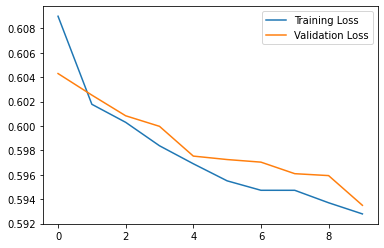

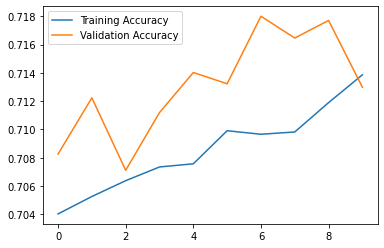

In [100]:
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend()
plt.show()

# Plot the training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()

### Model Evaluation 

* Examine your models (coefficients, parameters, errors, etc...)

* Compute and interpret your results in terms of accuracy, precision, recall, ROC etc. 

In [101]:
## Your code begins here
# Evaluating CNN model
test_loss, test_acc = cnn_model.evaluate(X_test, y_test)

# Make predictions
y_pred = cnn_model.predict(X_test)

629/629 [==============================] - 2s 2ms/step


In [102]:
# Evaluate model on test set
y_pred = cnn_model.predict(X_test)
y_pred_binary = np.round(y_pred)
accuracy = accuracy_score(y_test, y_pred_binary)
precision = precision_score(y_test, y_pred_binary)
recall = recall_score(y_test, y_pred_binary)
f1 = f1_score(y_test, y_pred_binary)

# Print performance metrics
print('Accuracy: {:.3f}'.format(accuracy))
print('Precision: {:.3f}'.format(precision))
print('Recall: {:.3f}'.format(recall))
print('F1 score: {:.3f}'.format(f1))

629/629 [==============================] - 1s 2ms/step
Accuracy: 0.703
Precision: 0.589
Recall: 0.062
F1 score: 0.112


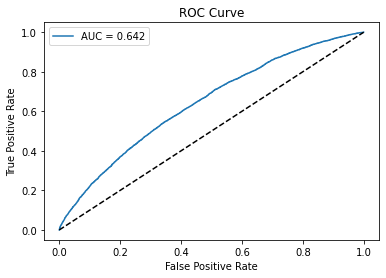

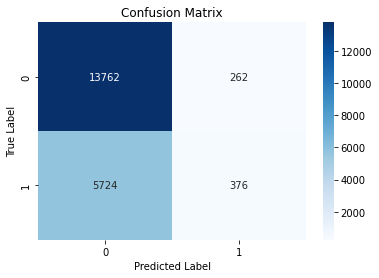

In [103]:
# Calculate ROC curve and AUC score
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred)

# Plot ROC curve
plt.plot(fpr, tpr, label='AUC = {:.3f}'.format(auc))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred_binary)

# Plot confusion matrix
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [104]:
# Evaluate model on test set
y_pred = model.predict(X_test)
y_pred_binary = np.round(y_pred)
accuracy = accuracy_score(y_test, y_pred_binary)
precision = precision_score(y_test, y_pred_binary)
recall = recall_score(y_test, y_pred_binary)
f1 = f1_score(y_test, y_pred_binary)

# Print performance metrics
print('Accuracy: {:.3f}'.format(accuracy))
print('Precision: {:.3f}'.format(precision))
print('Recall: {:.3f}'.format(recall))
print('F1 score: {:.3f}'.format(f1))

629/629 [==============================] - 3s 3ms/step
Accuracy: 0.699
Precision: 0.577
Recall: 0.032
F1 score: 0.061


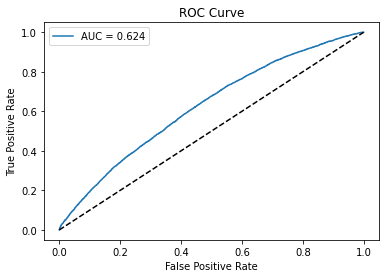

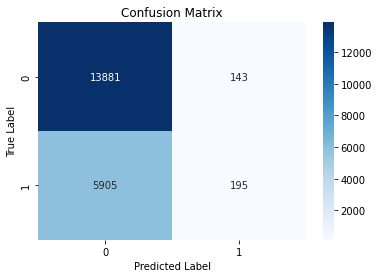

In [105]:
# Calculate ROC curve and AUC score
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred)

# Plot ROC curve
plt.plot(fpr, tpr, label='AUC = {:.3f}'.format(auc))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred_binary)

# Plot confusion matrix
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [106]:
# Evaluating GRU model
test_loss, test_acc = best_model.evaluate(X_test, y_test)

# Make predictions
y_pred = best_model.predict(X_test)

629/629 [==============================] - 11s 15ms/step


In [107]:
# Evaluate model on test set
y_pred = best_model.predict(X_test)
y_pred_binary = np.round(y_pred)
accuracy = accuracy_score(y_test, y_pred_binary)
precision = precision_score(y_test, y_pred_binary)
recall = recall_score(y_test, y_pred_binary)
f1 = f1_score(y_test, y_pred_binary)

# Print performance metrics
print('Accuracy: {:.3f}'.format(accuracy))
print('Precision: {:.3f}'.format(precision))
print('Recall: {:.3f}'.format(recall))
print('F1 score: {:.3f}'.format(f1))

629/629 [==============================] - 8s 13ms/step
Accuracy: 0.713
Precision: 0.669
Recall: 0.105
F1 score: 0.181


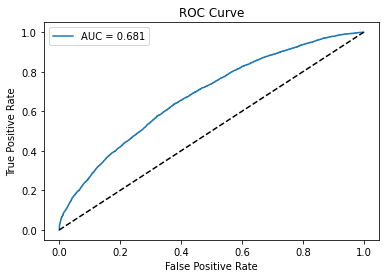

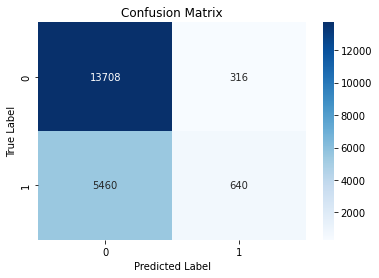

In [108]:
# Calculate ROC curve and AUC score
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred)

# Plot ROC curve
plt.plot(fpr, tpr, label='AUC = {:.3f}'.format(auc))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred_binary)

# Plot confusion matrix
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

### Issues / Improvements
Initially we tried different models using CNN, LSTM and GRU. GRU showed better accuracy and hence we further performed hypertuning. Considering The Accuracy and Precision, we found that GRU performed better.

###  References
   -•	Lu, S., Xu, L., Ye, X., & Wu, Y. (2021). Heart rate variability derived from photoplethysmography and mortality in critically ill patients: A retrospective study. Journal of Clinical Medicine, 10(19), 4295. 

•	Guo, Q., Zhao, Y., Wang, T., Zhang, C., Guo, J., & Xie, Y. (2021). Early detection of sepsis using photoplethysmography-based features in intensive care unit patients. Journal of Medical Systems, 45(11), 106.

•	Nguyen HB, Rivers EP, Knoblich BP, et al. Early lactate clearance is associated with improved outcome in severe sepsis and septic shock. Crit Care Med. 2004;32(8):1637-1642. doi:10.1097/01.ccm.0000132904.35713.a7

•	Jones AE, Kline JA. Use of goal-directed therapy for severe sepsis and septic shock in academic emergency departments. Crit Care Med. 2005;33(8):1888-1889. doi:10.1097/01.ccm.0000172224.52664.4a

•	Vandromme MJ, Griffin RL, Kerby JD, et al. Identifying risk for massive transfusion in the relatively normotensive patient: utility of the prehospital shock index. J Trauma. 2011;70(2):384-388. doi:10.1097/TA.0b013e318207c0b6
•	Dazhi Jiang a b, Geng Tu a, Donghui Jin a, Kaichao Wu a, Cheng Liu a b, Lin Zheng a b, Teng Zhou a b c

	

In [ ]:
# End of Project